Dataset shape: (15818, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15818 entries, 0 to 15817
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Width                               15818 non-null  float64
 1   Length                              15818 non-null  float64
 2   Floors                              15818 non-null  float64
 3   Rooms                               15818 non-null  float64
 4   Toilets                             15818 non-null  float64
 5   Price per m2                        15818 non-null  float64
 6   1 Part Residential                  15818 non-null  int64  
 7   All Residential                     15818 non-null  int64  
 8   Back Expansion                      15818 non-null  int64  
 9   Car Alley                           15818 non-null  int64  
 10  Frontage                            15818 non-null  int64  
 11  No Residential

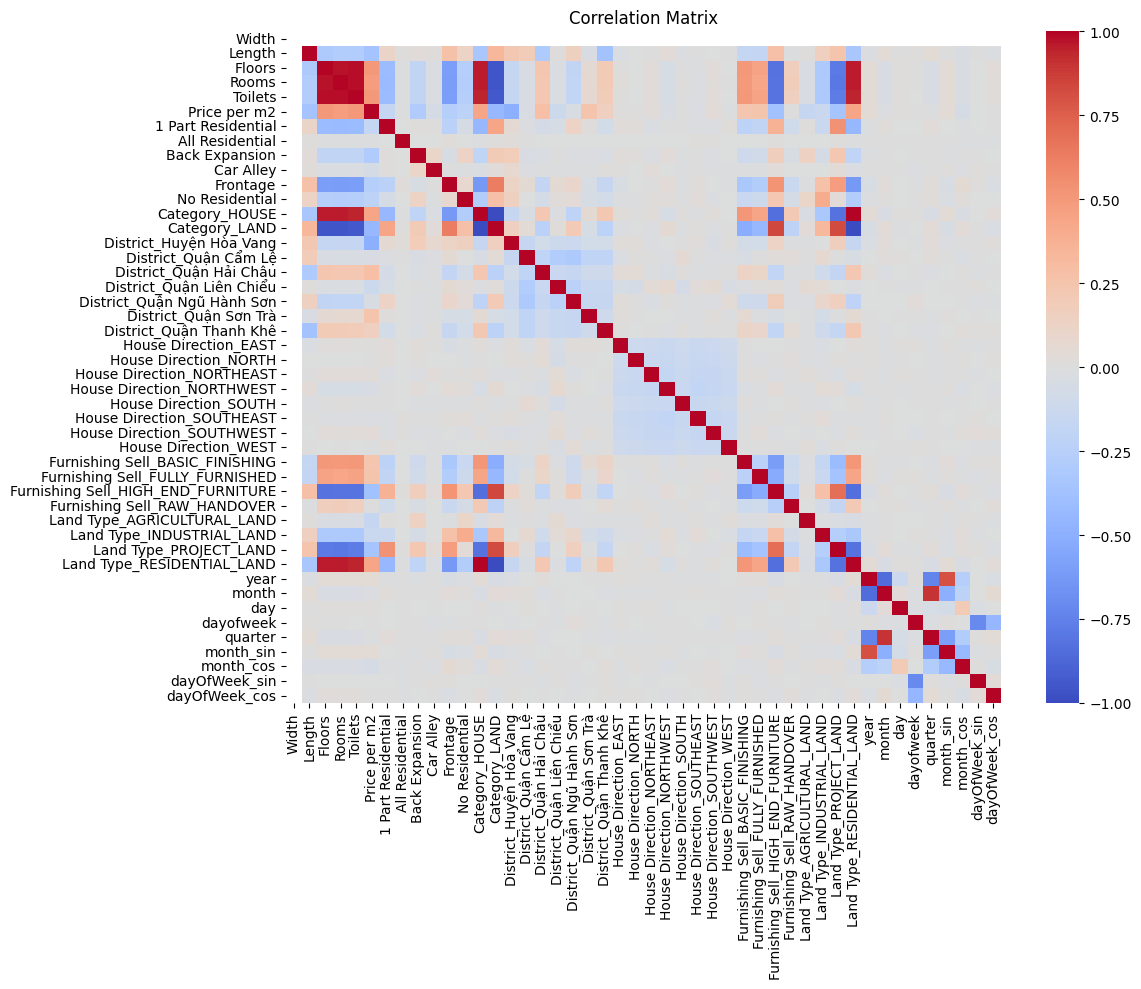

Top 10 features correlated with Price per m2:
 Toilets                               0.503340
Floors                                0.503004
District_Huyện Hòa Vang               0.501752
Rooms                                 0.479243
Category_LAND                         0.438315
Land Type_RESIDENTIAL_LAND            0.438315
Category_HOUSE                        0.438315
Furnishing Sell_HIGH_END_FURNITURE    0.381624
Length                                0.366886
Land Type_PROJECT_LAND                0.354476
Name: Price per m2, dtype: float64
X_train: (12654, 45), X_test: (3164, 45)
Loading pre-trained models...
Models loaded successfully!

Fitting base models...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

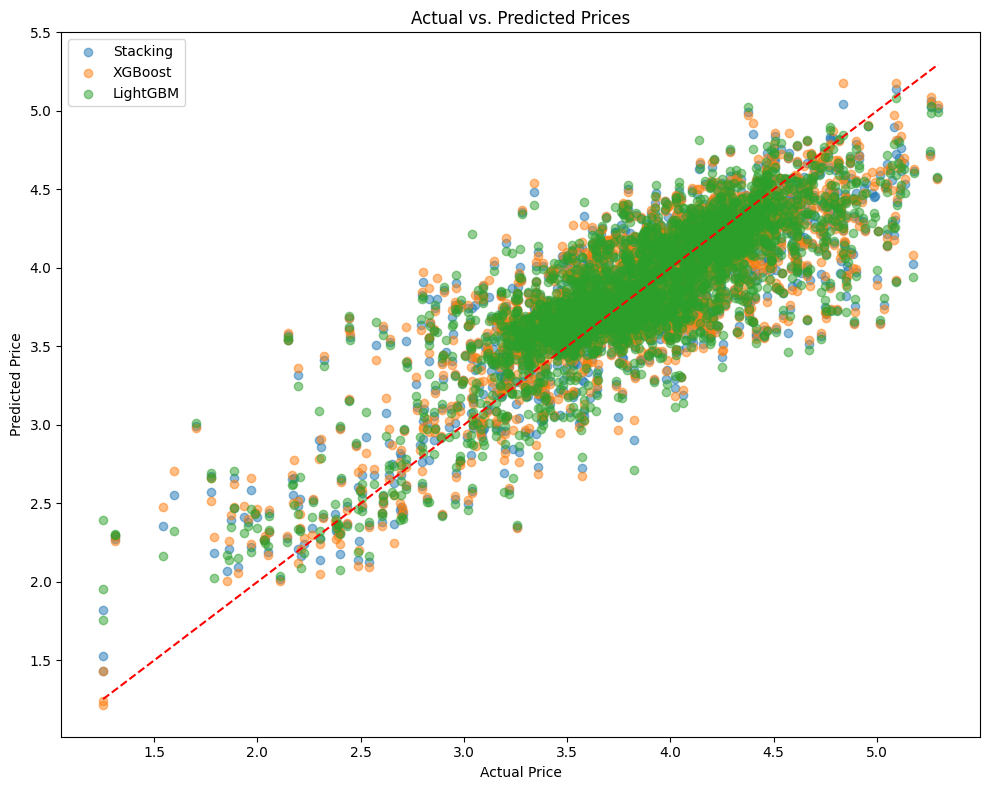

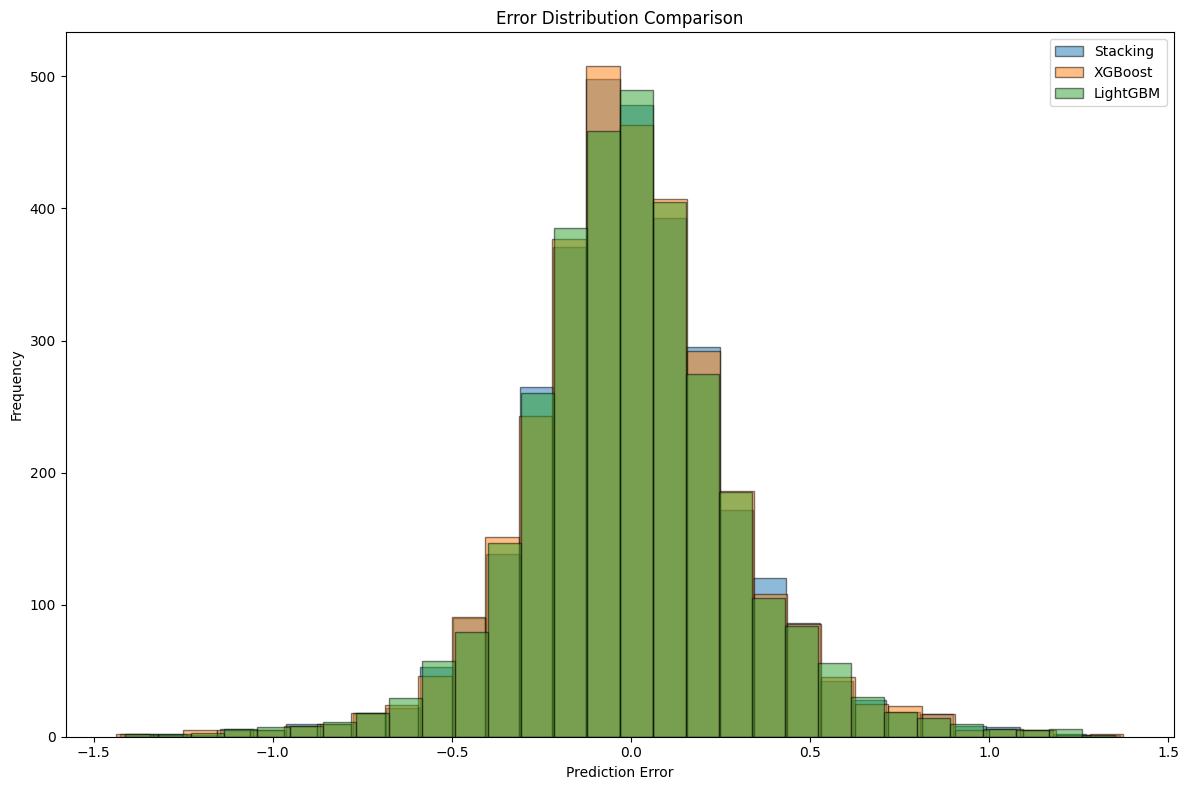


Training final ensemble model on full dataset...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 390
[LightGBM] [Info] Number of data points in the train set: 15818, number of used features: 41
[LightGBM] [Info] Start training from score 3.841247
Created weighted ensemble with weights: XGB=0.6, LGB=0.4
Saving final ensemble model...
Saved final ensemble model to ensemble_final_model.pkl

Generating 90-day forecast with ensemble model...
Forecast preview (first 5 days):
        Date  Predicted_Price_per_m2
0 2025-05-07                4.325756
1 2025-05-08                4.218675
2 2025-05-09                4.229562
3 2025-05-10                4.215279
4 2025-05-11                4.175635

Forecast previe

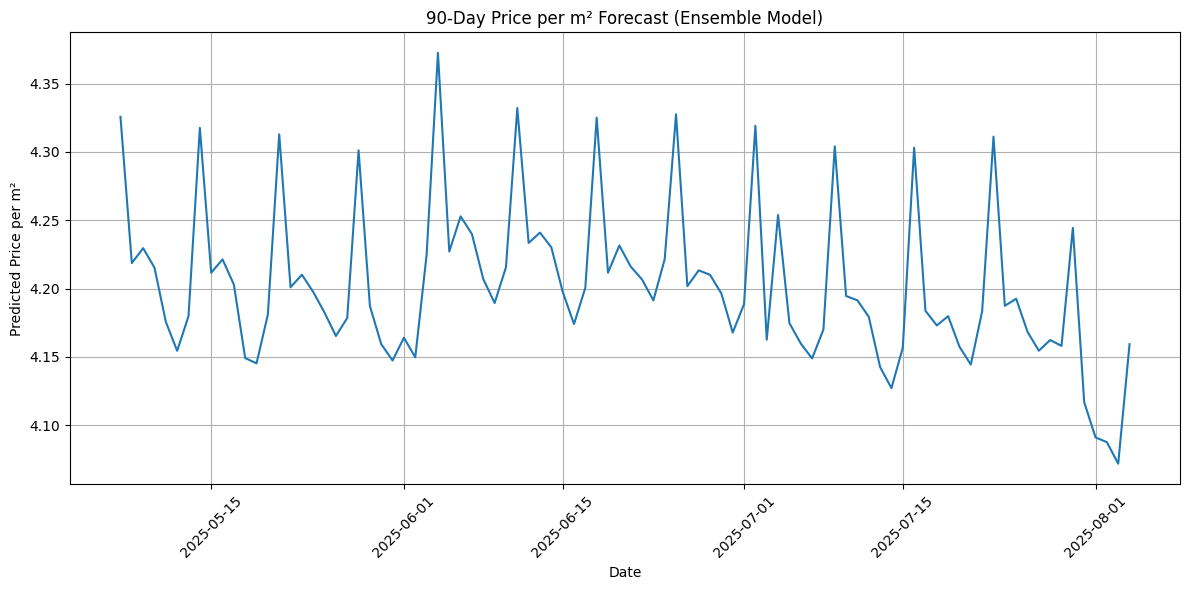


Comparing forecasts from all models...


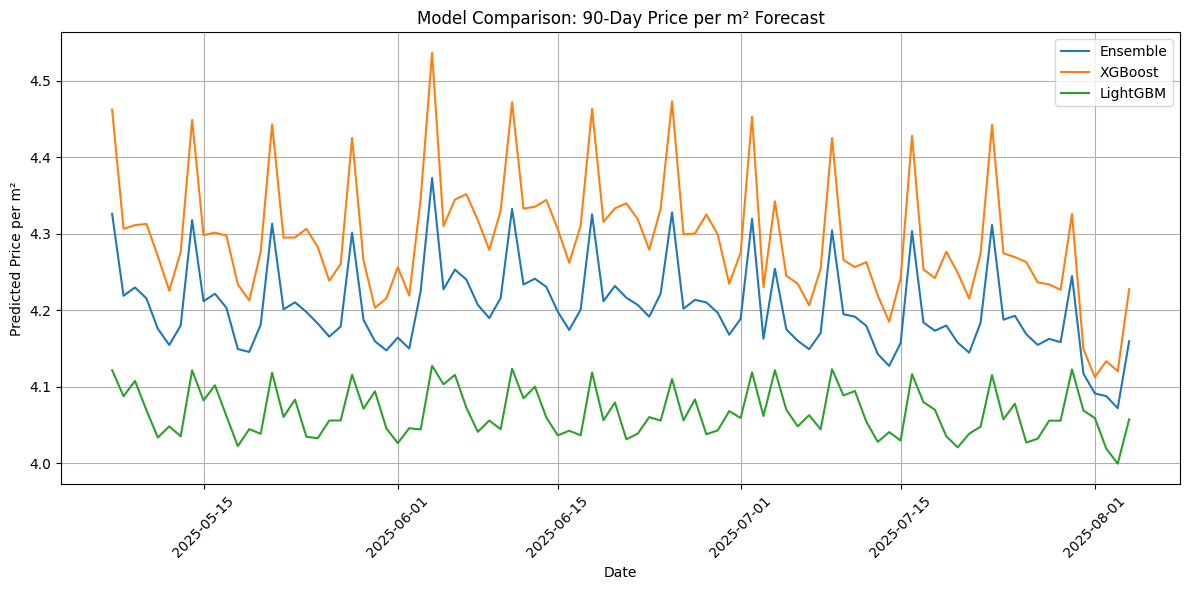

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import pickle
import os
from datetime import timedelta

# Load the dataset
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(f"Dataset shape: {df.shape}")
df.head()

# Feature engineering - temporal features
df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter

# Cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Drop datetime column
df.drop(columns=['Posted Time'], inplace=True)

# Display information about the dataframe
print(df.info())

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# Top features correlated with target
corr_with_price = df.corr()['Price per m2'].abs().sort_values(ascending=False).drop('Price per m2')
print("Top 10 features correlated with Price per m2:\n", corr_with_price.head(10))

# Split data
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=26
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# Load pre-trained models
print("Loading pre-trained models...")
try:
    with open('xgboost_final_model.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
    
    with open('lightgbm_final_model.pkl', 'rb') as f:
        lgb_model = pickle.load(f)
        
    print("Models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}")
    # Create basic models in case loading fails
    print("Creating new base models...")
    
    # Basic XGBoost
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=26
    )
    
    # Basic LightGBM
    lgb_model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=26
    )

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Train predictions
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"=== {model_name} Evaluation ===")
    print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
    print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")
    
    return {
        'train_mse': mse_train, 'train_rmse': rmse_train, 
        'train_mae': mae_train, 'train_r2': r2_train,
        'test_mse': mse_test, 'test_rmse': rmse_test, 
        'test_mae': mae_test, 'test_r2': r2_test,
        'test_pred': y_test_pred
    }

# Ensure models are fit on the training data
print("\nFitting base models...")
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Evaluate individual models
print("\nEvaluating individual models:")
xgb_metrics = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, "XGBoost")
lgb_metrics = evaluate_model(lgb_model, X_train, y_train, X_test, y_test, "LightGBM")

# Create and train stacking ensemble
print("\nBuilding stacking ensemble model...")

# First, create out-of-fold predictions for meta-model training
# This is critical to prevent information leakage that could cause poor generalization
print("Generating out-of-fold predictions for meta-model training...")

# Use the loaded models directly and generate OOF predictions
kf = KFold(n_splits=5, shuffle=True, random_state=26)

# Arrays to store out-of-fold predictions
xgb_oof_preds = np.zeros(X_train.shape[0])
lgb_oof_preds = np.zeros(X_train.shape[0])

# Generate OOF predictions
for train_idx, val_idx in kf.split(X_train):
    # Split data
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train XGBoost
    xgb_fold = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=26
    )
    xgb_fold.fit(X_fold_train, y_fold_train)
    xgb_oof_preds[val_idx] = xgb_fold.predict(X_fold_val)
    
    # Train LightGBM
    lgb_fold = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=26
    )
    lgb_fold.fit(X_fold_train, y_fold_train)
    lgb_oof_preds[val_idx] = lgb_fold.predict(X_fold_val)

# Create a meta-features dataset
meta_features_train = np.column_stack([xgb_oof_preds, lgb_oof_preds])

# Generate base model predictions on test set
xgb_test_preds = xgb_model.predict(X_test)
lgb_test_preds = lgb_model.predict(X_test)
meta_features_test = np.column_stack([xgb_test_preds, lgb_test_preds])

# Try different meta-models with hyperparameter tuning
meta_models = {
    'ridge': [Ridge(alpha=a) for a in [0.001, 0.01, 0.1, 0.5, 1.0, 5.0]],
    'lasso': [Lasso(alpha=a) for a in [0.0001, 0.001, 0.01, 0.1]],
    'elastic': [ElasticNet(alpha=a, l1_ratio=r) for a in [0.001, 0.01, 0.1] for r in [0.1, 0.5, 0.9]]
}

best_meta_model = None
best_meta_params = None
best_score = float('inf')

# Train and evaluate different meta-models
print("\nTesting different meta-models...")
for name, models in meta_models.items():
    for i, model in enumerate(models):
        print(f"\nTesting {name} model with parameters: {model.get_params()}")
        
        # Train meta-model
        model.fit(meta_features_train, y_train)
        
        # Make predictions
        y_pred = model.predict(meta_features_test)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{name} #{i+1} - MSE: {mse:.5f}, RMSE: {rmse:.5f}, MAE: {mae:.5f}, R2: {r2:.5f}")
        
        # Track the best model
        if mse < best_score:
            best_score = mse
            best_meta_model = model
            best_meta_params = {"type": name, "params": model.get_params()}
            best_preds = y_pred

print(f"\nBest meta-model: {best_meta_params}")

# Create a final stacking model with the best meta-model
# This time we will use proper feature scaling for the meta-model inputs
scaler = StandardScaler()
meta_features_train_scaled = scaler.fit_transform(meta_features_train)
meta_features_test_scaled = scaler.transform(meta_features_test)

# Train best meta-model on scaled data
best_meta_model.fit(meta_features_train_scaled, y_train)
best_preds_scaled = best_meta_model.predict(meta_features_test_scaled)

# Evaluate the scaled meta-model
mse = mean_squared_error(y_test, best_preds_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, best_preds_scaled)
r2 = r2_score(y_test, best_preds_scaled)
print(f"\nBest meta-model with scaling - MSE: {mse:.5f}, RMSE: {rmse:.5f}, MAE: {mae:.5f}, R2: {r2:.5f}")

# Also try a simple weighted average approach (aka Voting)
# Sometimes simpler ensembling methods can outperform stacking
print("\nTrying weighted average ensemble...")
for xgb_weight in [0.3, 0.4, 0.5, 0.6, 0.7]:
    lgb_weight = 1 - xgb_weight
    y_weighted_pred = xgb_weight * xgb_test_preds + lgb_weight * lgb_test_preds
    
    mse = mean_squared_error(y_test, y_weighted_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_weighted_pred)
    r2 = r2_score(y_test, y_weighted_pred)
    
    print(f"Weights (XGB: {xgb_weight:.1f}, LGB: {lgb_weight:.1f}) - MSE: {mse:.5f}, RMSE: {rmse:.5f}, R2: {r2:.5f}")
    
    if mse < best_score:
        best_score = mse
        best_weighted_preds = y_weighted_pred
        best_weights = (xgb_weight, lgb_weight)
        weighted_metrics = {
            'test_mse': mse, 
            'test_rmse': rmse, 
            'test_mae': mae, 
            'test_r2': r2,
            'test_pred': y_weighted_pred
        }

# Determine which approach is best
if 'best_weighted_preds' in locals() and best_score == mean_squared_error(y_test, best_weighted_preds):
    print(f"\nWeighted average is best with weights XGB: {best_weights[0]}, LGB: {best_weights[1]}")
    best_ensemble_type = "weighted"
    stack_metrics = weighted_metrics
    
    # Create a simple custom model class for weighted predictions
    class WeightedEnsemble:
        def __init__(self, models, weights):
            self.models = models
            self.weights = weights
        
        def predict(self, X):
            preds = [model.predict(X) for model in self.models]
            return sum(w * p for w, p in zip(self.weights, preds))
    
    # Create the final model - FIX: Assign this to best_stack_model
    best_stack_model = WeightedEnsemble(
        models=[xgb_model, lgb_model],
        weights=[best_weights[0], best_weights[1]]
    )
else:
    print(f"\nMeta-model is best: {best_meta_params}")
    best_ensemble_type = "meta"
    
    # Create proper metrics dict for the scaled meta-model
    stack_metrics = {
        'test_mse': mean_squared_error(y_test, best_preds_scaled),
        'test_rmse': np.sqrt(mean_squared_error(y_test, best_preds_scaled)),
        'test_mae': mean_absolute_error(y_test, best_preds_scaled),
        'test_r2': r2_score(y_test, best_preds_scaled),
        'test_pred': best_preds_scaled
    }
    
    # Create a custom ensemble that combines model prediction and scaling
    class ScaledMetaEnsemble:
        def __init__(self, base_models, meta_model, scaler):
            self.base_models = base_models
            self.meta_model = meta_model
            self.scaler = scaler
        
        def predict(self, X):
            # Get base model predictions
            base_preds = [model.predict(X) for model in self.base_models]
            meta_features = np.column_stack(base_preds)
            
            # Scale features
            meta_features_scaled = self.scaler.transform(meta_features)
            
            # Get meta-model predictions
            return self.meta_model.predict(meta_features_scaled)
    
    # Create final model - FIX: Assign to best_stack_model
    best_stack_model = ScaledMetaEnsemble(
        base_models=[xgb_model, lgb_model],
        meta_model=best_meta_model,
        scaler=scaler
    )

# Final evaluation - Now best_stack_model is properly defined
stack_metrics = evaluate_model(best_stack_model, X_train, y_train, X_test, y_test, "Final Stacking Model")

# Visualize predictions vs actuals
plt.figure(figsize=(10, 8))
plt.scatter(y_test, stack_metrics['test_pred'], alpha=0.5, label='Stacking')
plt.scatter(y_test, xgb_metrics['test_pred'], alpha=0.5, label='XGBoost')
plt.scatter(y_test, lgb_metrics['test_pred'], alpha=0.5, label='LightGBM')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Visualize error distributions
plt.figure(figsize=(12, 8))

# Calculate errors
stack_errors = y_test - stack_metrics['test_pred']
xgb_errors = y_test - xgb_metrics['test_pred']
lgb_errors = y_test - lgb_metrics['test_pred']

plt.hist(stack_errors, bins=30, alpha=0.5, label='Stacking', edgecolor='k')
plt.hist(xgb_errors, bins=30, alpha=0.5, label='XGBoost', edgecolor='k')
plt.hist(lgb_errors, bins=30, alpha=0.5, label='LightGBM', edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution Comparison")
plt.legend()
plt.tight_layout()
plt.savefig('error_distribution.png')
plt.show()

# Train the final model on the complete dataset
print("\nTraining final ensemble model on full dataset...")

# We need different approaches based on what worked best
if best_ensemble_type == "weighted":
    # For weighted approach, we need to train base models on full dataset
    xgb_model.fit(X, y)
    lgb_model.fit(X, y)
    
    # Create a simple custom model class for weighted predictions
    class WeightedEnsemble:
        def __init__(self, models, weights):
            self.models = models
            self.weights = weights
        
        def predict(self, X):
            preds = [model.predict(X) for model in self.models]
            return sum(w * p for w, p in zip(self.weights, preds))
    
    # Create the final model
    final_stack_model = WeightedEnsemble(
        models=[xgb_model, lgb_model],
        weights=[best_weights[0], best_weights[1]]
    )
    
    print(f"Created weighted ensemble with weights: XGB={best_weights[0]}, LGB={best_weights[1]}")
    
else:  # best_ensemble_type == "meta"
    # For meta-model approach, we need to:
    # 1. Generate predictions from base models on full dataset
    # 2. Train meta-model on these predictions
    
    # Generate predictions from base models
    xgb_full_preds = xgb_model.predict(X)
    lgb_full_preds = lgb_model.predict(X)
    meta_features_full = np.column_stack([xgb_full_preds, lgb_full_preds])
    
    # Scale features
    meta_features_full_scaled = scaler.fit_transform(meta_features_full)
    
    # Create a fresh instance of the best meta-model
    if best_meta_params["type"] == "ridge":
        final_meta_model = Ridge(**best_meta_params["params"])
    elif best_meta_params["type"] == "lasso":
        final_meta_model = Lasso(**best_meta_params["params"])
    else:  # elastic
        final_meta_model = ElasticNet(**best_meta_params["params"])
    
    # Train meta-model
    final_meta_model.fit(meta_features_full_scaled, y)
    
    # Create a custom ensemble that combines model prediction and scaling
    class ScaledMetaEnsemble:
        def __init__(self, base_models, meta_model, scaler):
            self.base_models = base_models
            self.meta_model = meta_model
            self.scaler = scaler
        
        def predict(self, X):
            # Get base model predictions
            base_preds = [model.predict(X) for model in self.base_models]
            meta_features = np.column_stack(base_preds)
            
            # Scale features
            meta_features_scaled = self.scaler.transform(meta_features)
            
            # Get meta-model predictions
            return self.meta_model.predict(meta_features_scaled)
    
    # Create final model
    final_stack_model = ScaledMetaEnsemble(
        base_models=[xgb_model, lgb_model],
        meta_model=final_meta_model,
        scaler=scaler
    )
    
    print(f"Created meta-model ensemble with {best_meta_params['type']} meta-model")

# Save the final ensemble model
print("Saving final ensemble model...")
with open('ensemble_final_model.pkl', 'wb') as f:
    pickle.dump(final_stack_model, f)

# Save to resources directory for backend
output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)
with open(output_dir + 'ensemble_final_model.pkl', 'wb') as f:
    pickle.dump(final_stack_model, f)

print("Saved final ensemble model to ensemble_final_model.pkl")

# Function for forecasting
def generate_forecast(model, X_base, days=90):
    # Start date for forecast: today
    start_date = pd.Timestamp.now().normalize()
    
    # Take the last row as base features
    base = X_base.iloc[-1].copy()
    
    results = []
    for i in range(days):
        date = start_date + timedelta(days=i)
        f = base.copy()
        
        # Update time features
        f['year'] = date.year
        f['month'] = date.month
        f['day'] = date.day
        f['dayofweek'] = date.weekday()
        f['quarter'] = date.quarter
        
        # Update cyclical features
        f['month_sin'] = np.sin(2 * np.pi * date.month / 12)
        f['month_cos'] = np.cos(2 * np.pi * date.month / 12)
        f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
        f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)
        
        # Make prediction
        X_pred = f.values.reshape(1, -1)
        
        # Use appropriate prediction method based on model type
        try:
            pred_price = model.predict(X_pred)[0]
        except:
            # Handle other model types (like our custom ensemble)
            pred_price = model.predict(X_pred)
            # Ensure we have a scalar value
            if isinstance(pred_price, np.ndarray):
                pred_price = pred_price[0]
        
        results.append({
            'Date': date,
            'Predicted_Price_per_m2': pred_price
        })
    
    forecast_df = pd.DataFrame(results)
    return forecast_df

# Generate forecast with ensemble model
print("\nGenerating 90-day forecast with ensemble model...")
forecast_df = generate_forecast(final_stack_model, X)

print("Forecast preview (first 5 days):")
print(forecast_df.head())
print("\nForecast preview (last 5 days):")
print(forecast_df.tail())

# Save forecast to CSV
forecast_df.to_csv('price_forecast_ensemble.csv', index=False)
print("Saved forecast to price_forecast_ensemble.csv")

# Visualize forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'])
plt.title('90-Day Price per m² Forecast (Ensemble Model)')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m²')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('price_forecast_ensemble.png')
plt.show()

# Compare forecasts from different models
print("\nComparing forecasts from all models...")
xgb_forecast = generate_forecast(xgb_model, X)
lgb_forecast = generate_forecast(lgb_model, X)

plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], label='Ensemble')
plt.plot(xgb_forecast['Date'], xgb_forecast['Predicted_Price_per_m2'], label='XGBoost')
plt.plot(lgb_forecast['Date'], lgb_forecast['Predicted_Price_per_m2'], label='LightGBM')
plt.title('Model Comparison: 90-Day Price per m² Forecast')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m²')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('forecast_comparison.png')
plt.show()


In [2]:

# Print conclusion
print("\n=== Conclusion ===")
print(f"XGBoost Test: MSE: {xgb_metrics['test_mse']:.5f}, RMSE: {xgb_metrics['test_rmse']:.5f}, R2: {xgb_metrics['test_r2']:.5f}")
print(f"LightGBM Test: MSE: {lgb_metrics['test_mse']:.5f}, RMSE: {lgb_metrics['test_rmse']:.5f}, R2: {lgb_metrics['test_r2']:.5f}")
print(f"Ensemble Test: MSE: {stack_metrics['test_mse']:.5f}, RMSE: {stack_metrics['test_rmse']:.5f}, R2: {stack_metrics['test_r2']:.5f}")

# Calculate improvements
xgb_improvement = (1 - stack_metrics['test_mse']/xgb_metrics['test_mse'])*100
lgb_improvement = (1 - stack_metrics['test_mse']/lgb_metrics['test_mse'])*100

print(f"\nImprovement over XGBoost: {xgb_improvement:.2f}%")
print(f"Improvement over LightGBM: {lgb_improvement:.2f}%")

# Add a more detailed analysis
if xgb_improvement > 0 and lgb_improvement > 0:
    print("\nThe ensemble model successfully improves over both base models!")
    better_than = "both XGBoost and LightGBM"
elif xgb_improvement > 0:
    print("\nThe ensemble model improves over XGBoost but not LightGBM.")
    better_than = "XGBoost"
elif lgb_improvement > 0:
    print("\nThe ensemble model improves over LightGBM but not XGBoost.")
    better_than = "LightGBM"
else:
    print("\nThe ensemble model doesn't improve over either base model.")
    better_than = "neither"
    print("\nThis suggests that:")
    print("1. The base models may already be capturing most of the signal in the data")
    print("2. The base models might be making similar errors, making it hard for an ensemble to improve")
    print("3. The ensemble approach might need further tuning")
    
    # Find best individual model
    best_base_mse = min(xgb_metrics['test_mse'], lgb_metrics['test_mse'])
    best_base = "XGBoost" if xgb_metrics['test_mse'] <= lgb_metrics['test_mse'] else "LightGBM"
    print(f"\nRecommendation: Use the {best_base} model which has the lowest MSE of {best_base_mse:.5f}")


=== Conclusion ===
XGBoost Test: MSE: 0.08946, RMSE: 0.29909, R2: 0.68242
LightGBM Test: MSE: 0.09109, RMSE: 0.30181, R2: 0.67662
Ensemble Test: MSE: 0.08879, RMSE: 0.29798, R2: 0.68479

Improvement over XGBoost: 0.74%
Improvement over LightGBM: 2.52%

The ensemble model successfully improves over both base models!
